# M1a - Reading and Writing routines

The first deliverable for the **PREDATOR** project Milestone M1 was to develop data reading and writing routines for the most common raw data and image data formats.
Currently, the [DeepMR](https://github.com/INFN-PREDATOR/deep-mr) framework includes the following I/O routines:

* **[MRD](https://onlinelibrary.wiley.com/doi/10.1002/mrm.26089)** format: this is the most widely accepted vendor-agnostic MR raw data format (read-only);
* **DICOM** format: this is the most common image data format used in clinical environment (read and write);
* **NIfTI** format: this is the most common image data format used in neuroimaging research (read and write).

In addition, a reader for MR raw data in the native GE HealthCare formats (**PFiles** and **ScanArchives**) is available on a private repository for research centers with a GEHC Research Agreement.
These routines are designed to allow the use of image reconstruction algorithm developed using the [DeepMR](https://github.com/INFN-PREDATOR/deep-mr) framework on real world data.

Here, we show an example consisting of 1) reading a publicly available Non-Cartesian MR raw data in **MRD** format, 2) reconstructing the corresponding image and 3) saving the result in **DICOM** format.

In [1]:
%matplotlib inline
import copy

import numpy as np
import matplotlib.pyplot as plt # for displaying the results

import deepmr

## 1. Reading MR rawdata

In [2]:
# example dataset
rawpath = deepmr.testdata("mrd")

# load the rawdata
raw, head = deepmr.io.read_rawdata(rawpath)

Here, `raw` is a complex-valued PyTorch tensor containing the k-space measurements, of shape `(nslices, ncoils, ncontrasts, nviews, nsamples)`:

In [3]:
print(f"Raw datatype: {raw.dtype}")
print(f"Raw shape: {raw.shape}")

Raw datatype: torch.complex64
Raw shape: torch.Size([1, 36, 1, 32, 1284])


i.e., a single-slice dataset acquired with a 36-channels coil and sampled with a multi-shot trajectory with 32 views and 1284 samples per view.

The other output, `head`, is a structure containing all the information for image reconstruction (e.g., sampling trajectory, image matrix size) or fitting (e.g., Flip Angle, Echo Time, Repetition Time) and correct visualization on medical viewers (e.g., resolution, orientation, slice spacing):

In [4]:
print(f"K-space trajectory shape: {head.traj.shape}")
print(f"Image resolution: {head.resolution} [mm]")
print(f"Image orientation: {head._orientation}") # this is private, normally used internally by image export routines
print(f"Acquisition flip angle: {head.FA} [deg]")
print(f"Acquisition Echo Time (TE): {head.TE} [ms]")
print(f"Acquisition Repetition Time (TR): {head.TR} [ms]")

K-space trajectory shape: torch.Size([1, 32, 1284, 2])
Image resolution: tensor([5.0000, 1.5625, 1.5625], dtype=torch.float64)
Image orientation: [0.0, 0.0, 1.0, 0.0, 1.0, 0.0]


i.e., this is a Non-Cartesian dataset with spatial resolution `(dx, dy, dz) = (1.5625, 1.5625, 5.0) mm` acquired with a sagittal orientation and `flip angle` / `TE` / `TR` set to `10.0 deg`, `0.86` ms and `4.96 ms`, respectively. The trajectory reflects the MR raw data shape, the axis representing `(ncontrasts, nviews, nsamples, axis)`, with `axis=0` representing `x`, `axis=1`  representing `y` and `axis=2` (3D acquisition only) representing `z` directions, respectively. 

K-space data and sampling trajectory have the following appearance:

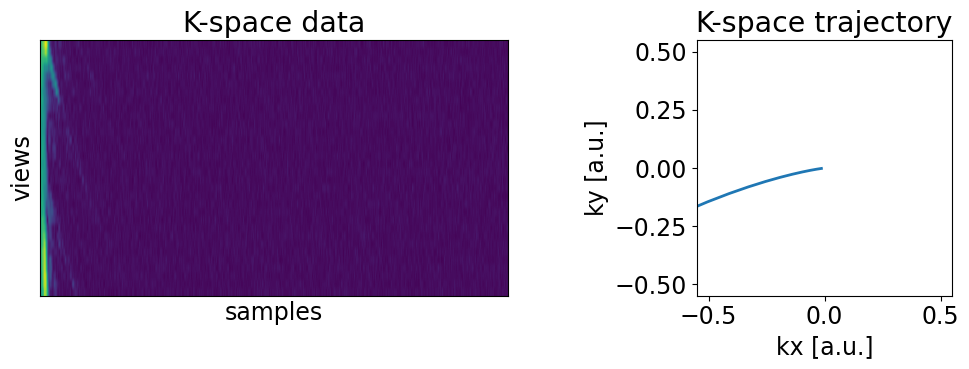

In [5]:
# raw data
plt.rcParams['figure.figsize'] = [11, 4]
plt.subplot(1, 2, 1)
_ = plt.imshow(abs(raw[0, 0, 0]), aspect='auto')
plt.title("K-space data")
plt.xticks([]),plt.yticks([])
_ = plt.xlabel("samples")
_ = plt.ylabel("views")

# trajectory
plt.subplot(1, 2, 2)
_ = plt.plot(head.traj[0, 0, :, 0], head.traj[0, 0, :, 1]) # displaying a single interleaf
plt.axis("square")
plt.ylim([-0.55, 0.55])
plt.xlim([-0.55, 0.55])
_ = plt.title("K-space trajectory")
_ = plt.xlabel("kx [a.u.]"), plt.ylabel("ky [a.u.]")
plt.tight_layout()

## 2. Reconstructing image

[DeepMR](https://github.com/INFN-PREDATOR/deep-mr) provides a lot of tools for image reconstruction. These will be better delineated in **PREDATOR** deliverables **M1b** and **M1c**; here, we perform a simple direct Non-Uniform Fast Fourier Transform (NUFFT) inversion with sum-of-squares combination of the individual coil images:

In [6]:
# get trajectory, matrix size and density compensation factors
traj = head.traj # k-space trajectory (ncontrasts, nviews, nsamples, ndims)
dcf = head.dcf # k-space density compensation function (ncontrasts, nviews, nsamples)
shape = head.shape[-2:] # image matrix shape (ny, nx)

# perform reconstruction
img = deepmr.fft.nufft_adj(dcf * raw, traj, shape) # (nslices=1, ncoils, ncontrasts=1, ny, nx)
img = img.squeeze() # (ncoils, ny, nx)

# perform coil combination
img_sos = deepmr.rss(img, axis=0) # (ny, nx)
img_sos = abs(img_sos) # take the real-valued magnitude

# prepare individual coil images for plotting
img = img.reshape(6, 6, *img.shape[-2:])
img = [np.concatenate([img[i][j] for j in range(img.shape[1])], axis=-1) for i in range(img.shape[0])]
img = np.concatenate(img, axis=0)

The reconstructed, coil combined image will have the following appearance:

(-0.5, 191.5, 191.5, -0.5)

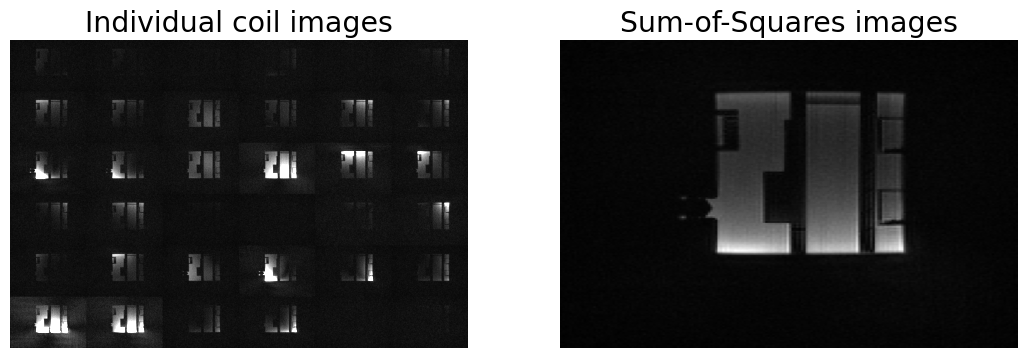

In [7]:
# individual coil data
plt.rcParams['figure.figsize'] = [13, 4]
plt.subplot(1, 2, 1)
_ = plt.imshow(abs(img), aspect='auto', cmap="gray", vmax=1e-5)
plt.title("Individual coil images")
plt.axis("off")

# combined data
plt.rcParams['figure.figsize'] = [11, 4]
plt.subplot(1, 2, 2)
_ = plt.imshow(img_sos, aspect='auto', cmap="gray")
plt.title("Sum-of-Squares image")
plt.axis("off")

## 3. Export to disk

Now, we can either save our image to **DICOM** format (e.g., for inspection on a clinical viewer system) or to **NIfTI** format (i.e., for quantitative statistical measurements using external tools. Since NIfTI format is not really suited for single-slice images and it is more oriented towards 3D volumes, here we focus on DICOM:


In [26]:
# saving to DICOM
deepmr.io.write_image("test_m1a_dicom", img_sos[None, None, ...], copy.deepcopy(head), "dicom", filepath="../output/", rescale=True)

# loading for verification
img_dcm, head_dcm = deepmr.io.read_image("../output/test_m1a_dicom")
img_dcm = abs(img_dcm).squeeze()

The DICOM image, besides intensity scaling to accomodate for the expected integer data format for pixel values in DICOM standard, is the same as the reconstructed:

(-0.5, 191.5, 191.5, -0.5)

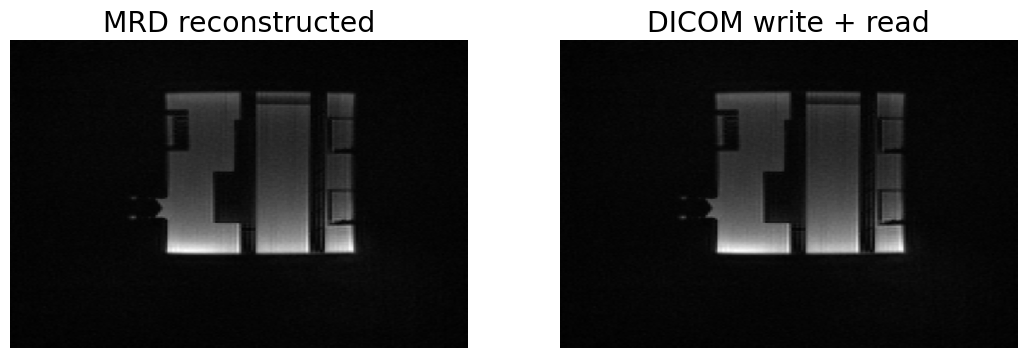

In [30]:
# MRD reconstructed
plt.rcParams['figure.figsize'] = [13, 4]
plt.subplot(1, 2, 1)
_ = plt.imshow(img_sos, aspect='auto', cmap="gray")
plt.title("MRD reconstructed")
plt.axis("off")

# combined data
plt.subplot(1, 2, 2)
_ = plt.imshow(img_dcm, aspect='auto', cmap="gray")
plt.title("DICOM write + read")
plt.axis("off")

In addition, the operation preserved the acquisition header information:

In [41]:
print(f"Image resolution for exported DICOM: {head_dcm.resolution}")
print(f"Image orientation for exported DICOM: {head_dcm._orientation}") # this is private, normally used internally by image export routines
print(f"Acquisition flip angle for exported DICOM: {head_dcm.FA} [deg]")
print(f"Acquisition Echo Time (TE) for exported DICOM: {head_dcm.TE} [ms]")
print(f"Acquisition Repetition Time (TR) for exported DICOM: {head_dcm.TR} [ms]")

Image resolution for exported DICOM: tensor([5.0000, 1.5600, 1.5600], dtype=torch.float64)
Image orientation for exported DICOM: [0.0, 0.0, 1.0, 0.0, 1.0, 0.0]
Acquisition flip angle for exported DICOM: 10.0 [deg]
Acquisition Echo Time (TE) for exported DICOM: 0.8600000143051147 [ms]
Acquisition Repetition Time (TR) for exported DICOM: 4.960000038146973 [ms]
